# Analysis of 300 Solar Homes in NSW Australia

This notebook studies the normalised load and PV generation profile in NSW Australia. <br>
Data of 300 solar homes recorded from 2012 June to 2013 May are processed. <br>
The csv files can be found in the website of Ausgrid as below: <br>
https://www.ausgrid.com.au/Industry/Our-Research/Data-to-share/Solar-home-electricity-data

Please download the followings:
- Solar home half-hour data - 1 July 2012 to 30 June 2013
- Solar home half-hour data - 1 July 2011 to 30 June 2012

In [17]:
#Import module
import os;
os.system ("cls");
import math
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
from datetime import date, timedelta;
%matplotlib inline

#Read two Ausgrid files: 2011-2012 & 2012-2013 for 300 solar home
solar_data_2011_2012=pd.read_csv("2011-2012 Solar home electricity data v2.csv",header=1);
solar_data_2012_2013=pd.read_csv("2012-2013 Solar home electricity data v2.csv",header=1);

#Combine two files together to form data from June 2012 - May 2013 
solar_data_2011_2012['date']=pd.to_datetime(solar_data_2011_2012['date'],format='%d/%m/%Y');
solar_data_2012_2013['date']=pd.to_datetime(solar_data_2012_2013['date'],format='%d/%m/%Y');
solar_data=solar_data_2011_2012[solar_data_2011_2012.date.dt.month==6].append(solar_data_2012_2013[solar_data_2012_2013.date.dt.month!=6], ignore_index=True);

#Data cleaning: customer 2 is found to have empty data for serveral month 
solar_data=solar_data[solar_data.Customer!=2];
No_of_customer=299;

#Get sepcific column 
month=solar_data.date.dt.month;
load_type=solar_data['Consumption Category'];
time_series=solar_data.columns[5:-1];#heading of half-hour gap in each day

#Index of specific season for data
winter_period=(month==6) | (month==7) | (month==8);#92 days
spring_period=(month==9) | (month==10) | (month==11); #91 days
summer_period=(month==12) | (month==1) | (month==2);#90 days
autumn_period=(month==3) | (month==4) | (month==5);#92 days
year_period= (winter_period) | (spring_period) | (summer_period) | (autumn_period);
season=[winter_period,spring_period,summer_period,autumn_period,year_period];

#Index of loadtype
GL_loadtype=load_type=='GC';#general load
CL_loadtype=load_type=='CL';#controlled load
PV_loadtype=load_type=='GG';#PV generation

#define date for each season for manipulation of data
winter_daterange=pd.date_range(date(2012, 6, 1),date(2012, 8, 31));
spring_daterange=pd.date_range(date(2012, 9, 1),date(2012,11, 30));
summer_daterange=pd.date_range(date(2012, 12, 1),date(2013, 2, 28));
autumn_daterange=pd.date_range(date(2013, 3, 1),date(2013, 5, 31));
whole_year_daterange=pd.date_range(date(2012, 6, 1),date(2013, 5, 31));
season_daterange=[winter_daterange,spring_daterange,summer_daterange,autumn_daterange, whole_year_daterange];

No_of_days_winter=len(winter_daterange);
No_of_days_spring=len(spring_daterange);
No_of_days_summer=len(summer_daterange);
No_of_days_autumn=len(autumn_daterange);
No_of_days_year=No_of_days_winter+No_of_days_spring+No_of_days_summer+No_of_days_autumn;
No_of_days_season=[No_of_days_winter,No_of_days_spring,No_of_days_summer,No_of_days_autumn,No_of_days_year]

#string for plotting
season_str=['Winter','Spring','Summer','Autumn','All Seasons'];

## Big picture of 300 solar homes
The PV capacity against daily load size are shown in the scatter plot and frequency histograms below.

In [18]:
#find the load type: PV/load consumption
PV_solar_data=solar_data[PV_loadtype];
load_solar_data=solar_data[GL_loadtype|CL_loadtype];

#PV: find the capacity of each customer
#Load: find the average daily consumption over the year 
group_PV=(PV_solar_data.groupby('Customer')['Generator Capacity']).mean();  group_PV.name='PV Capacity (kWp)';
group_load=(load_solar_data.groupby('Customer')[time_series]).mean().sum(axis=1); group_load.name='Load (kWh)';
Load_vs_capacity = pd.merge(group_PV, group_load, right_index = True, 
               left_index = True)

#Mean load for each custer during a season
solar_home_load=(solar_data[GL_loadtype|CL_loadtype]).groupby(['Customer','date'])[time_series];
solar_home_PV=(solar_data[PV_loadtype].groupby(['Customer','date']))[time_series];

load_by_customer_by_day=solar_home_load.sum().sum(axis=1);
PV_by_customer_by_day=solar_home_PV.sum().sum(axis=1);

load_by_customer_by_day.name='Daily Load (kWh)';
PV_by_customer_by_day.name='Daily PV Generation (kWh)';


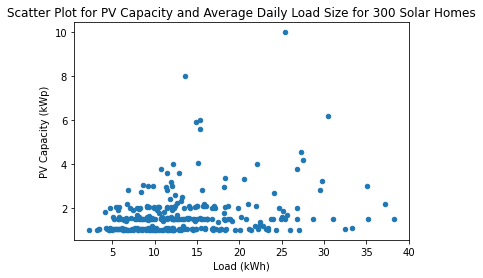

In [19]:
#scatter plot to study the relationship between PV capacity and load size
scp = Load_vs_capacity.plot.scatter(y='PV Capacity (kWp)', x='Load (kWh)');
plt.title("Scatter Plot for PV Capacity and Average Daily Load Size for 300 Solar Homes")
plt.show()

The scatter plot shows that majority of customers are with both small load size and PV capacity.
Most cutomers have PV capacity of below 2KWp
Since data being processed are in year of 2012 and 2013
It is expected that the points will shift upward because solar panels become more commercialised.

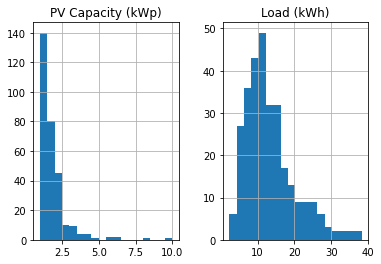

In [20]:
#frequency histogram plot
N_sqrt=math.ceil(No_of_customer**0.5);#No. of bins for histograms
Load_vs_capacity.hist(bins=N_sqrt);

Apart from scatter plot, the PV capacity and load size of customers are groupped in the two histograms above.
y-axis are the number of customers for specific range of PV capacity or load size.
The number of bins is chosen to be the square-root of sample size (No. of customers)
For both PV capacity and load size, the No. of customers peaked at small value and then dropped quickly.
This shows a log-normal distribution.

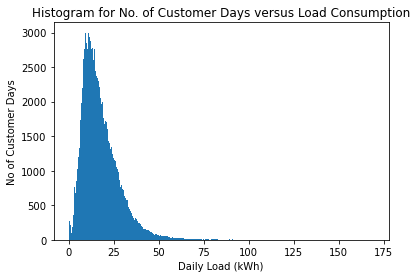

In [21]:
N_customer_days=len(PV_by_customer_by_day);
N_sqrt=math.ceil(N_customer_days**0.5);#No of bin for histograms

#histogram for load
plt.hist(load_by_customer_by_day,bins=N_sqrt);
plt.xlabel('Daily Load (kWh)');
plt.ylabel('No of Customer Days');
plt.title('Histogram for No. of Customer Days versus Load Consumption');
plt.show();

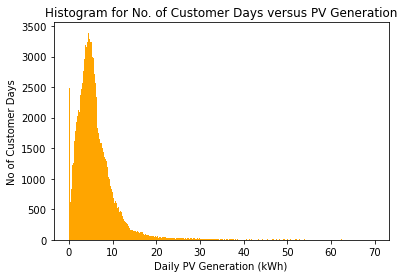

In [22]:
#histogram for PV
plt.hist(PV_by_customer_by_day,bins=N_sqrt,color='orange');
plt.xlabel('Daily PV Generation (kWh)');
plt.ylabel('No of Customer Days');
plt.title('Histogram for No. of Customer Days versus PV Generation');  
plt.show();

A peak at roughly 0 kWh is shown since negligible electricity is generated on some cloudy days over the year. 

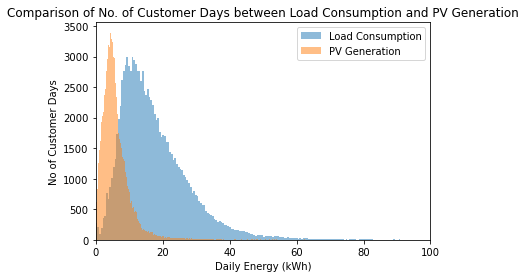

In [23]:
#Combine two histograms together
plt.figure();
plt.hist(load_by_customer_by_day,bins=N_sqrt,alpha=0.5,label='Load Consumption');
plt.hist(PV_by_customer_by_day,bins=N_sqrt,alpha=0.5,label='PV Generation');
plt.xlabel('Daily Energy (kWh)');
plt.ylabel('No of Customer Days');
plt.xlim(0, 100)
plt.legend()
plt.title('Comparison of No. of Customer Days between Load Consumption and PV Generation');

The relationship between No. of customer days against load consumption and PV generation is also studied.
Looking at the above histogram, we can clearly observe that load consumption is generally higher than PV generation,
and the PV generation distribution shows a smaller variation than load consumption.

## Normalised load and PV generation profiles
Boxplots showing the variation of normalised value and a curve showing the mean of normalised value are merged into the same graph. <br>
Three analysis are included. 

# 1) Hour-wise Analysis (varied by customers)

The normalised load and PV generation against 48 time instants of a day are studied. \
Detail of the plot: \
x-axis: 48 time instants of a day \
y-axis: normalised energy of load/PV \
boxplot: variation of 300 customers 

In [24]:
#Group by Customer
solar_home_load=(solar_data[GL_loadtype|CL_loadtype]).groupby('Customer')[time_series];
solar_home_PV=(solar_data[PV_loadtype].groupby('Customer'))[time_series];

#Step 1:
#Find the half-hourly average Load Consumption/maximum PV generation for each customer over the whole year
#Firstly sum all energy over the whole year at each time instant 
#Secondly find the mean(for load)/max(for PV) of a day
#Lastly scaling the data by dividing by No. of days of a year  
mean_load=solar_home_load.sum().mean(axis=1)/No_of_days_year;
max_PV=solar_home_PV.sum().max(axis=1)/No_of_days_year;

season_count=0;
Analysis_1_fig=[None]*10;
for specific_season in season:
    
    load_data_season=solar_data[specific_season & (GL_loadtype | CL_loadtype)];
    PV_data_season=solar_data[specific_season & PV_loadtype];
    
    load_by_customer=load_data_season.groupby('Customer')[time_series];
    PV_by_customer=PV_data_season.groupby('Customer')[time_series];
    
    #dataframe for boxplot
    #Similar to step 1
    #Firstly find the total energy for each customer at 48 half-hour instants over a specific season
    #Then normalised by value found in Step 1, 
    #Lastly scaling the data by the No. of days of a season
    Norm_load_by_customer=(load_by_customer.sum()/No_of_days_season[season_count])/np.array(mean_load)[:,None];
    Norm_PV_by_customer=(PV_by_customer.sum()/No_of_days_season[season_count])/np.array(max_PV)[:,None];
    
    #mean of normalised value over all customers
    norm_mean_load=Norm_load_by_customer.mean();
    norm_mean_PV=Norm_PV_by_customer.mean();

    #Load plot
    plt.figure(1)
    fig1, ax1 = plt.subplots()
    ax1.plot(list(range(1,len(norm_mean_load)+1)),norm_mean_load, 'r', linewidth=2,label='mean')
    box_plot_load=Norm_load_by_customer.plot.box(ax=ax1,showfliers=False);
    plt.xticks(np.arange(1,49,6))
    plt.title('Normalised Load Profiles for '+ season_str[season_count]+  ' Over the Year (2012 June - 2013 May)\n' )
    plt.xlabel('Time')
    plt.ylabel('Normalised Load Consumption')
    plt.ylim(0,2.5)
    plt.close();
    Analysis_1_fig[2*season_count]=fig1;
    
    #PV plot
    plt.figure(2)
    fig2, ax2 = plt.subplots()
    ax2.plot(list(range(1,len(norm_mean_PV)+1)), norm_mean_PV, 'r', linewidth=2,label='mean')
    box_plot_load=Norm_PV_by_customer.plot.box(ax=ax2,showfliers=False);
    plt.xticks(np.arange(1,49,6))
    plt.title('Normalised PV Generation Profiles for '+ season_str[season_count]+  ' Over the Year (2012 June - 2013 May)\n' )
    plt.xlabel('Time')
    plt.ylabel('Normalised PV Generation')
    plt.ylim(0,1.2)
    plt.close()
    Analysis_1_fig[2*season_count+1]=fig2;

    season_count+=1;
    if (season_count==3):
        Loadshape=norm_mean_load;
        PVshape=norm_mean_PV;
     

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

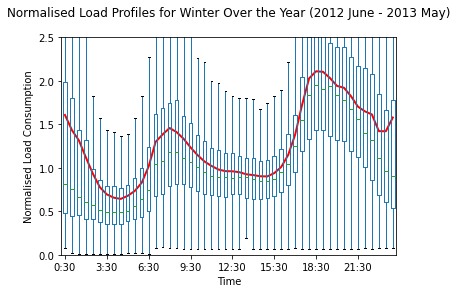

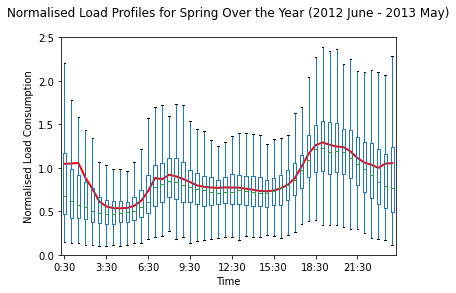

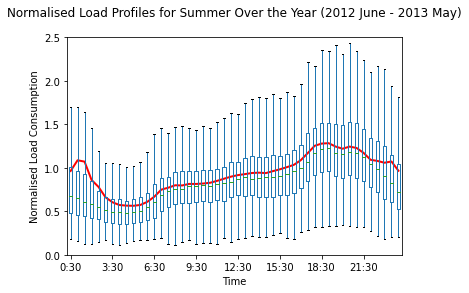

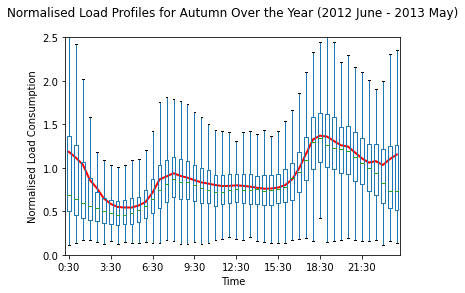

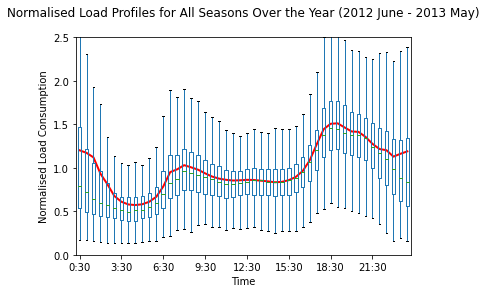

In [25]:
for i in range(0,10,2):
    display(Analysis_1_fig[i]);

Between 2012 and 2013, winter has a higher overall load consumption than Summer. Data from AEMO suggests that in NSW load consumption in winter are sometime higher than that in winter. 
 
In winter, the normalised load consumption fluctuated around 1.5. <br>
Peak period: 07:00- 09:00, 18:00 - 20:00 <br>
off peak period: 03:00- 06:00, 11:00 - 16:00 <br>

In summer, it shows smaller flucutation around 1.0 <br>
peak period: 17:30 - 21:30 <br>
off-peak period: 03:00 - 06:00

The shoulder period, autumn and spring, share similar load profile pattern. <br>
peak period: 18:00 - 20:00 <br>
off perak period: 03:00 - 06:00 <br>

A relatively long box plot than that in PV generation profile suggests that customer behaviour are highly varing  


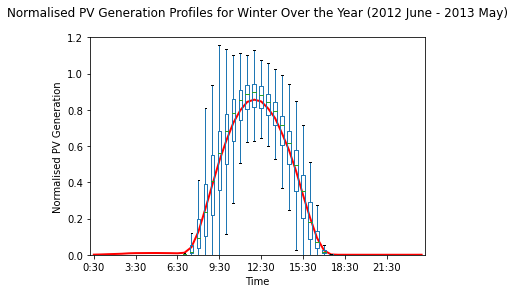

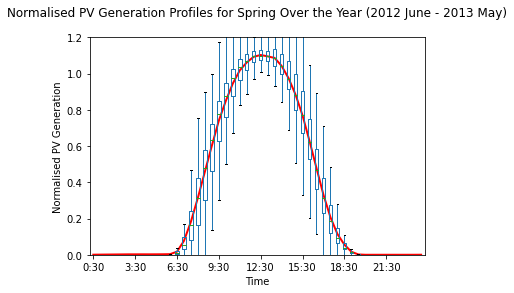

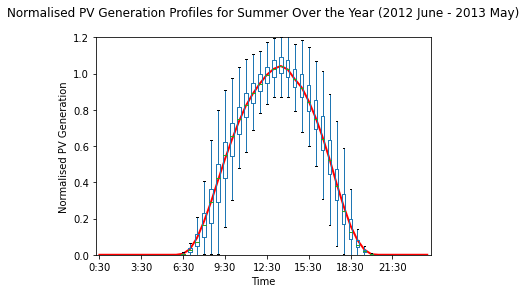

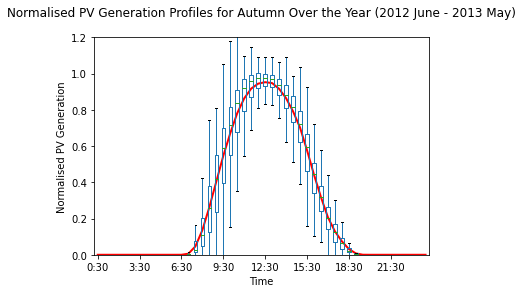

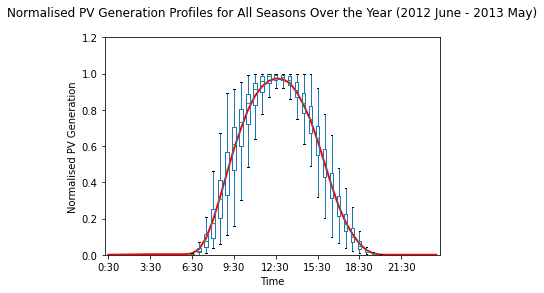

In [26]:
for i in range(0,10,2):
    display(Analysis_1_fig[i+1]);

Between 2012 and 2013, Spring and Summer have higher PV generation than Autumn and Winter <br>
Both Spring and Summer has PV generation peaked at normalised value higher than 1.0 <br>
For Autumn and Winter, the PV penetration only peaked at 0.95 and 0.85 repectively <br>

All seasons share similar PV genetration pattern, with PV penetration maximizes at 12:30 and decays gradually away from that. Note that Summer has the longest time each day for PV generation from 06:00 to 20:00 whereas Winter has the shortest time from 07:00 to 18:00 

We can see that PV generation profiles have smaller box length than profiles. This suggests that PV system is less variant by customer than load consumption behavior by customer.

# 2) Hour-wise Analysis (varied by days)
The normalised load and PV generation against 48 time instants of a day are studied. \
Detail of the plot: \
x-axis: 48 time instants of a day \
y-axis: normalised energy of load/PV \
boxplot: variation of days over the season or year

In [27]:
#Group by date
solar_home_load=(solar_data[GL_loadtype|CL_loadtype]).groupby('date')[time_series];
solar_home_PV=(solar_data[PV_loadtype].groupby('date'))[time_series];

#step 1:
#Find the half-hourly average load consumption/maximum PV generation
#Firstly sum energy over all customers then over the year  
#Secondly find the half-hourly mean(for load)/max(for PV) energy
#Lastly scaling the data by dividing by No. of days of a year  
mean_load=solar_home_load.sum().sum().mean()/No_of_days_year;
max_PV=solar_home_PV.sum().sum().max()/No_of_days_year;

season_count=0;
Analysis_2_fig=[None]*10;
for specific_season in season:
    
    #get different dataframe for loadtype then group by dates
    load_data_season=solar_data[specific_season & (GL_loadtype | CL_loadtype)];
    PV_data_season=solar_data[specific_season & PV_loadtype];
    
    load_by_date=load_data_season.groupby('date')[time_series];
    PV_by_customer=PV_data_season.groupby('date')[time_series];
    
    #dataframe for boxplot
    #normalised by value obtained in step 1
    Norm_load_by_date=(load_by_date.sum())/mean_load
    Norm_PV_by_customer=(PV_by_customer.sum())/max_PV
    
    #mean of normalised value over all customers
    norm_mean_load=Norm_load_by_date.mean();
    norm_mean_PV=Norm_PV_by_customer.mean();

    #Load plot
    plt.figure(1)
    fig1, ax1 = plt.subplots()
    ax1.plot(list(range(1,49)),norm_mean_load, 'r', linewidth=2,label='mean')
    box_plot_load=Norm_load_by_date.plot.box(ax=ax1,showfliers=False);
    plt.xticks(np.arange(1,49,6))
    plt.title('Normalised Load Profiles for '+ season_str[season_count]+  ' Over the Year (2012 June - 2013 May)\n' )
    plt.xlabel('Time')
    plt.ylabel('Normalised Load Consumption')
    plt.ylim(0,2.5)
    plt.close();
    Analysis_2_fig[2*season_count]=fig1;
    
    #PV plot
    plt.figure(2)
    fig2, ax2 = plt.subplots()
    ax2.plot(list(range(1,49)), norm_mean_PV, 'r', linewidth=2,label='mean')
    box_plot_load=Norm_PV_by_customer.plot.box(ax=ax2,showfliers=False);
    plt.xticks(np.arange(1,49,6))
    plt.title('Normalised PV Generation Profiles for '+ season_str[season_count]+  ' Over the Year (2012 June - 2013 May)\n' )
    plt.xlabel('Time')
    plt.ylabel('Normalised PV Generation')
    plt.ylim(0,1.3)
    plt.close()
    Analysis_2_fig[2*season_count+1]=fig2;
    season_count+=1;

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

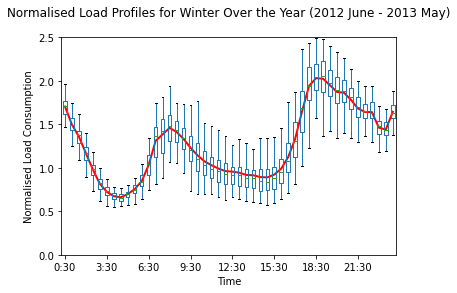

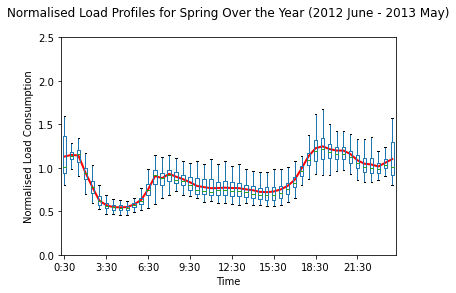

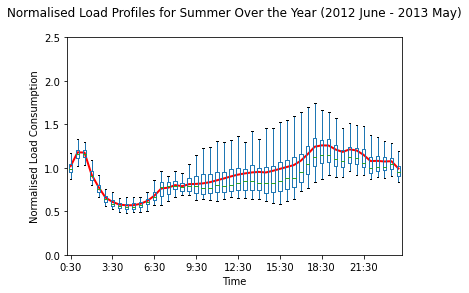

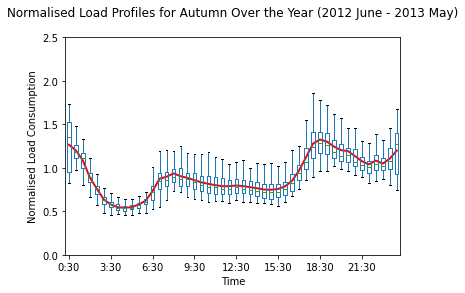

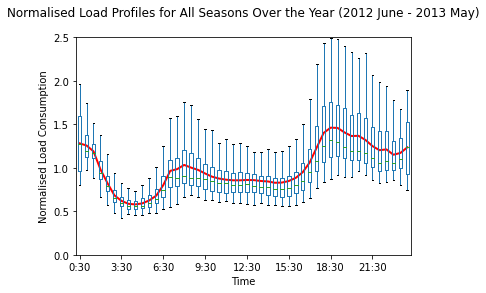

In [28]:
for i in range(0,10,2):
    display(Analysis_2_fig[i]);

The varied-by-day analysis has similar profile pattern as the varied-by-customer analysis. However, the box length is generally smaller because the daily load consumption pattern is not expected to vary a lot during a specific season. 

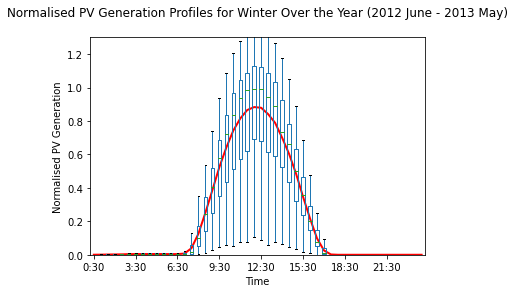

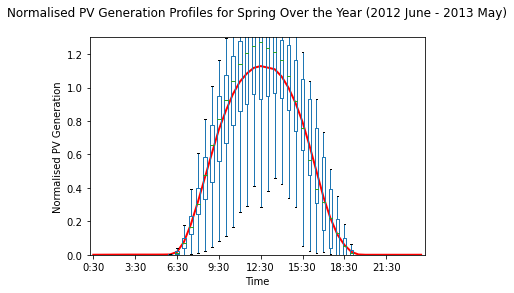

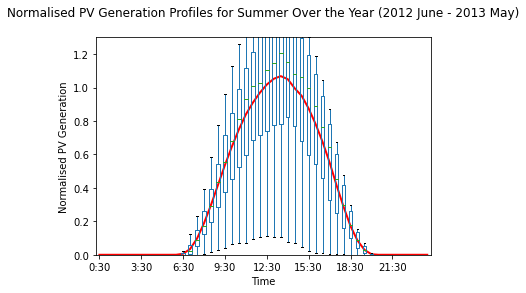

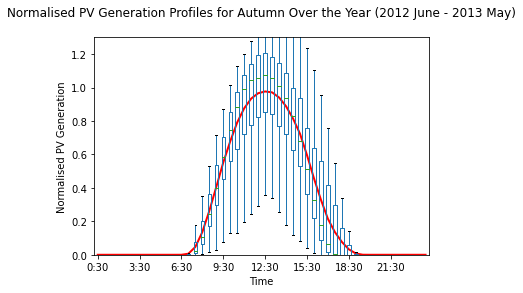

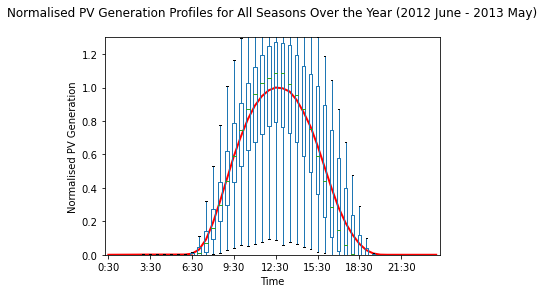

In [29]:
for i in range(0,10,2):
    display(Analysis_2_fig[i+1]);

By contrast, box length is greater for varied-by-day analysis. The reason is the amount of solar radiation received by PV panels varied a lot with weather condition each days among a season. 

# 3) Day-wise Analysis 
The normalised load and PV generation against days of specific seasons are studied. <br>
Detail of the plot: <br>
x-axis: days of a season <br>
y-axis: normalised energy of load/PV <br>
boxplot: variation of customers over a season

In [30]:
#Group by Customer and date
solar_home_load=(solar_data[GL_loadtype|CL_loadtype]).groupby(['Customer','date'])[time_series];
solar_home_PV=(solar_data[PV_loadtype].groupby(['Customer','date']))[time_series];

# find the average daily load consumption/ maximum PV generation over the year for each customer
mean_load=solar_home_load.sum().sum(axis=1).groupby('Customer').mean();
max_PV=solar_home_PV.sum().sum(axis=1).groupby('Customer').max()

season_count=0;
Analysis_3_fig=[None]*8;
for specific_season in season[0:-1]:
    
    load_data_season=solar_data[specific_season & (GL_loadtype | CL_loadtype)];
    PV_data_season=solar_data[specific_season & PV_loadtype];
    
    load_by_customer=load_data_season.groupby(['Customer','date'])[time_series];
    PV_by_customer=PV_data_season.groupby(['Customer','date'])[time_series];
    
    #data frame for box plot
    #find the daily consumption/PV generation for each customer each date
    #turn the manipulated data into a dataframe from series
    Norm_load_by_customer=(load_by_customer.sum().sum(axis=1)/mean_load).to_frame();
    Norm_PV_by_customer=(PV_by_customer.sum().sum(axis=1)/max_PV).to_frame();
    
    Norm_load_by_customer.reset_index(inplace=True);Norm_load_by_customer=Norm_load_by_customer.rename(columns = {0:'Norm_value'});
    Norm_PV_by_customer.reset_index(inplace=True);Norm_PV_by_customer=Norm_PV_by_customer.rename(columns = {0:'Norm_value'});
    
    Norm_load_by_customer=Norm_load_by_customer.pivot_table(index='Customer',columns='date',values='Norm_value');
    Norm_PV_by_customer=Norm_PV_by_customer.pivot_table(index='Customer',columns='date',values='Norm_value');
    
    #normalised mean for line plot
    norm_mean_load=Norm_load_by_customer.mean();
    norm_mean_PV=Norm_PV_by_customer.mean();
    
    #xticks selection for plotting
    daterange=season_daterange[season_count];
    first_day_of_month=(daterange.day==1);
    xtick_index=np.asarray(np.where(first_day_of_month))+1;
    xtick_index=np.concatenate((xtick_index[0], [No_of_days_season[season_count]]), axis=0);    
    Norm_load_by_customer.columns=Norm_load_by_customer.columns.strftime('%b-%d');
    Norm_PV_by_customer.columns=Norm_PV_by_customer.columns.strftime('%b-%d');
    
    #Load plot
    plt.figure(1)
    fig1, ax1 = plt.subplots()
    ax1.plot(list(range(1,len(norm_mean_load)+1)),norm_mean_load, 'r', label='mean')
    box_plot_load=Norm_load_by_customer.plot.box(ax=ax1,showfliers=False);
    plt.xticks(xtick_index,rotation=45)
    plt.title('Normalised Load Profiles for '+ season_str[season_count]+  ' Over the Year (2012 June - 2013 May)\n') 
    plt.xlabel('Day')
    plt.ylabel('Normalised Load Consumption')
    plt.ylim(0,2.5)
    plt.close();
    Analysis_3_fig[2*season_count]=fig1;
    
    #PV plot
    plt.figure(2)
    fig2, ax2 = plt.subplots()
    ax2.plot(list(range(1,len(norm_mean_PV)+1)), norm_mean_PV, 'r', label='mean')
    box_plot_load=Norm_PV_by_customer.plot.box(ax=ax2,showfliers=False);
    plt.xticks(xtick_index,rotation=45)
    plt.title('Normalised PV Generation Profiles for '+ season_str[season_count]+  ' Over the Year (2012 June - 2013 May)\n') 
    plt.xlabel('Day')
    plt.ylabel('Normalised PV Generation')
    plt.ylim(0,1)
    plt.close()
    Analysis_3_fig[2*season_count+1]=fig2;
    season_count+=1;    


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

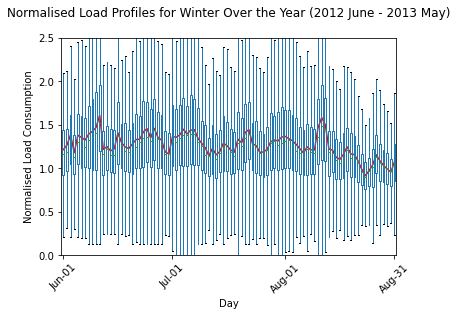

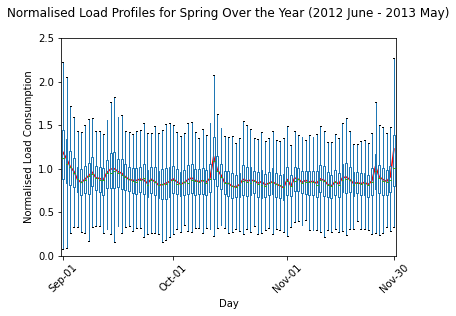

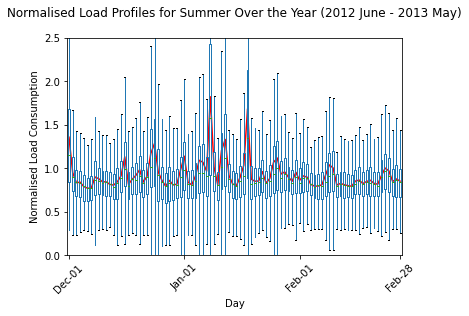

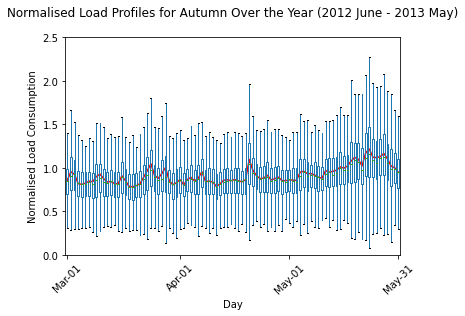

In [31]:
for i in range(0,8,2):
    display(Analysis_3_fig[i]);

The average load consumption varied slightly over days for all season except summer. Again, the daily consumption for each customer is expected to varied slightly day by day.

For summer, greater fluctuion is shown with obvious peaks for some days. The reason is certain days in Summer may have out-of-sudden higher temperature leading to larger air-conditioning loads.   

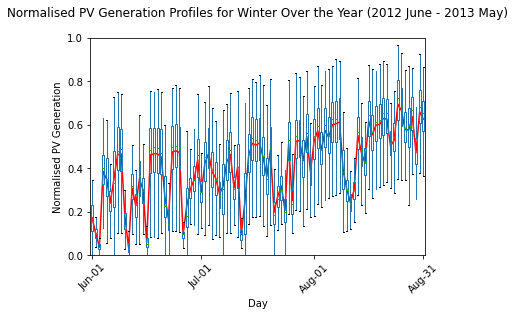

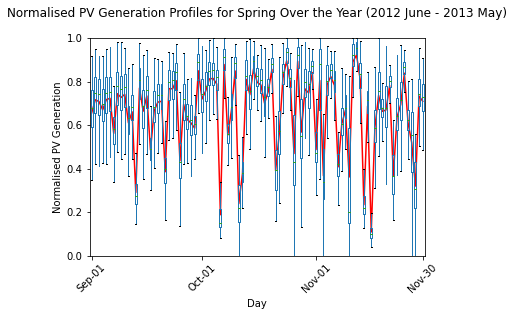

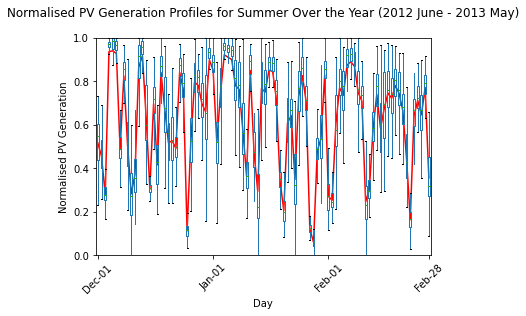

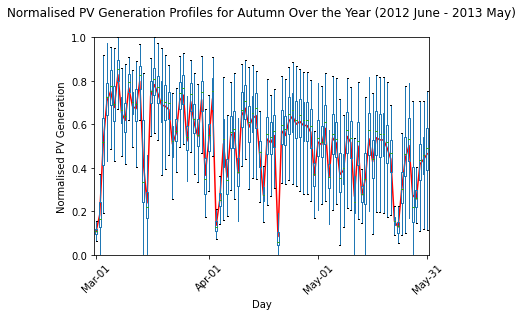

In [32]:
for i in range(0,8,2):
    display(Analysis_3_fig[i+1]);

The average PV generation varies greatly day-wise for all seasons due to the changing weather conditions each day. <br>
This demonstrates that solar power has disadvantage of low stability as a reliable energy source. 